# Best Practices - PyTorch YOLOX on COCO

## Optimizing YOLOX with NetsPresso Model Compressor
By following this notebook, the user can get YOLOX which has 1.44x low latency, 2.7x fewer parameters only with -1.06 mAP(0.5:0.95) drop by using NetsPresso Model Compressor.


This notebook contains the following 3 parts:
  1. [Model Compression with NetsPresso Model Compressor](#1.-Model-Compression-with-NetsPresso-Model-Compressor)
  2. [Fine-Tuning the Compressed Model](#2.-Fine-tuning-the-Compressed-Model)
  3. [Compression-Results](#3.-Compression-Results)
  
For more details about NetsPresso Model Compressor, please visit [Docs](https://docs.netspresso.ai/docs/technology-support-1) and [Netspresso.ai](https://www.netspresso.ai).


<div align="center">

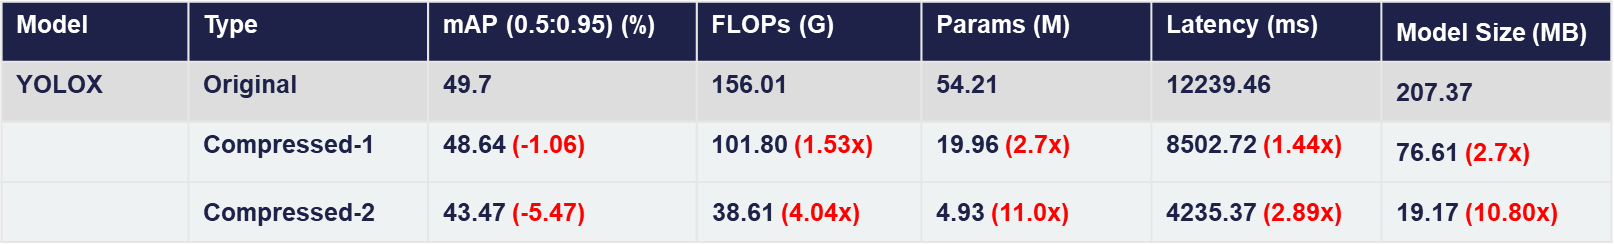
</div>
<div align='center'>
Fig. 1 Compression results of the YOLOX. The model's latency is measured using a Raspberry Pi 4B (1.5GHz ARM Cortex). We set the model's data type to FP32, and an inference engine to ONNX Runtime to measure the latency.
</div>


<a name="1.-Model-Compression-with-NetsPresso-Model-Compressor"></a>
# 1. Model Compression with NetsPresso Model Compressor

### Preparing the pre-trained YOLOX on COCO 

Downloading the pre-trained model

In [ ]:
! wget https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_l.pth

### Setting up your environment


Cloning the YOLOX code ([link](https://github.com/Megvii-BaseDetection/YOLOX))

In [ ]:
! git clone https://github.com/Megvii-BaseDetection/YOLOX.git

Installing the following packages:

In [ ]:
! apt-get -y update
! apt-get -y install libgl1-mesa-glx

! cd ./YOLOX && \
pip3 install -r requirements.txt && \
pip3 install -v -e . && \
pip3 install onnx-simplifier==0.4.7 && \
pip3 install onnx==1.10.2 && \
pip3 install easydict && \
pip3 install tensorboard && \
python setup.py develop

# You MUST install the compatible torch version with your cuda version. Here, we set PyTorch 1.12.0 with CUDA 11.3 as default. (Support: PyTorch version >= 1.10) 
! pip install torch==1.12.0+cu113 torchvision==0.13.0+cu113 torchaudio==0.12.0 --extra-index-url https://download.pytorch.org/whl/cu113

### **YOLOX compression using NetsPresso Model Compressor**

<a name='compGuide'></a>

__Compression Guide__ 
1. Sign up for NetsPresso Model Compressor ([link](https://compression.netspresso.ai/#/login)).
2. Upload the original YOLOX. The model should be converted into the ONNX format. Please check the below [code block](#Conversion-into-ONNX-Format) to convert the model.
3. To reproduce the best practice result, please select the following compression procedures one by one as depicted [here](#2.-Fine-tuning-the-Compressed-Model): 
    * For the first case of Fig. 1,
        * `L2 Norm Pruning` &rarr; `Recommendation(SLAMP) pruning ratio: 0.4`
    * For the second case,
        * `L2 Norm Pruning` &rarr; `Recommendation(SLAMP) pruning ratio: 0.7`
        
4. Press `Compress` button, and get the compressed model. The compression result will be shown as follow.

<!-- ---
* If it is hard to follow, please refer to the following user-guide video ([link](https://www.youtube.com/watch?v=MqTI212VQi0)). -->

<div align='center'>
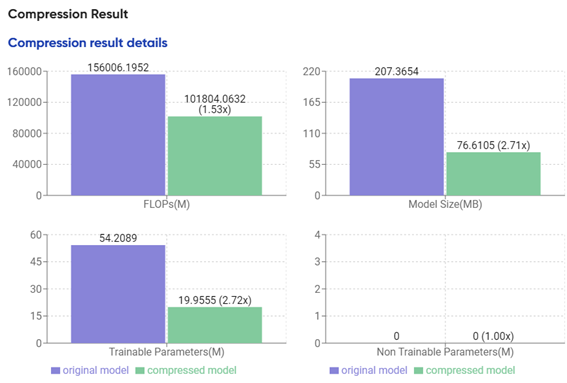
&nbsp; &nbsp; &nbsp; &nbsp;
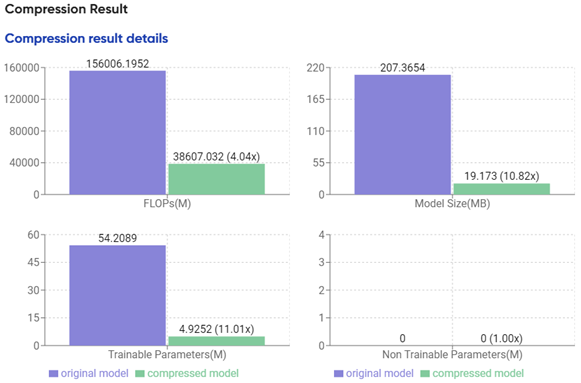
</div>
<div align='center'>
Fig 2. The results of each compression. Left: L2 Norm Pruning (0.4). Right: L2 Norm Pruning (0.7).
</div>

<a name="Conversion-into-ONNX-Format"></a>
### Conversion into ONNX format

1. If the model contains unsupported operators, it can occur an error. In YOLOX case, YOLOX calculates loss in the model's forward function, and unsupported operators are used in the calculating process.
To detach the calculating loss process from the model, we need to define the new [YOLOX](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/blob/main/best_practices/object_detection/torch/yolox_coco/yolox_woLoss.py) and [YOLO_Head](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/blob/main/best_practices/object_detection/torch/yolox_coco/yolo_head_woLoss.py).

In [ ]:
# 1) Download the codes about model without loss function 

! cd ./YOLOX/yolox/models && \
wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/main/best_practices/object_detection/torch/yolox_coco/yolox_woLoss.py && \
wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/main/best_practices/object_detection/torch/yolox_coco/yolo_head_woLoss.py

2. You should create a new experiment description file ([Exp file](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/blob/main/best_practices/object_detection/torch/yolox_coco/yolox_l_woLoss.py)) to use the newly defined YOLOX.

In [ ]:
# 2) Define new Exp file for the model
! cd ./YOLOX/exps/example/custom && \
wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/main/best_practices/object_detection/torch/yolox_coco/yolox_l_woLoss.py

3. The original repository provides [tools/export_onnx.py](https://github.com/Megvii-BaseDetection/YOLOX/blob/main/tools/export_onnx.py) to convert the model into ONNX format as evaluation mode. However, it only exports the model as evaluation mode, so you need to make a new exporting tool ([export_onnx_train.py](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/blob/main/best_practices/object_detection/torch/yolox_coco/export_onnx_train.py)) to get the model as training mode.

In [ ]:
# 3) Download the codes for exporting onnx model as Training mode. (Original code exports the model as Eval mode.)
! cd ./YOLOX/tools && \
wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/main/best_practices/object_detection/torch/yolox_coco/export_onnx_train.py

4. Convert the model into ONNX format. You will get `yolox_l.onnx`.

In [ ]:
! cd ./YOLOX && \
python tools/export_onnx_train.py --exp_file ./exps/example/custom/yolox_l_woLoss.py -c ../yolox_l.pth --output-name ../yolox_l.onnx

<a name="2.-Fine-tuning-the-Compressed-Model"></a>
# 2. Fine-tuning the Compressed Model
Structured pruning may induce the performance degradation, which requires additional fine-tuning process.  
Therefore, the fine-tuning process is necessary to compensate the performance after each compression process.  
Here, `Structured Pruning` &rarr; `Fine-tuning`

### Preparing COCO dataset

In [ ]:
! ln -s /your/COCO/Dataset/path ./YOLOX/datasets/COCO # ex) ! ln -s /content/drive/MyDrive/colab/dataset/COCO ./YOLOX/datasets/COCO

<a name='#fine-tuning'></a>
### Fine-tuning the compressed model

We need to set an experiment description file ([Exp file](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/blob/main/best_practices/object_detection/torch/yolox_coco/yolox_l_compressed_model_L2Norm_04.py)) for finetuning the compressed model.

In [ ]:
# Define new Exp file.
! cd ./YOLOX/exps/example/custom && \
wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/main/best_practices/object_detection/torch/yolox_coco/yolox_l_compressed_model_L2Norm_04.py 

Fine-tuning the compressed model



In this Notebook, we fine-tune ([link](#2.-Fine-tuning-the-Compressed-Model)) and verify ([link](#3.-Compression-Results)) the model for the first case of Fig. 1 by default.  
* `yolox_l_compressed_model_L2Norm_04.pt` means the model compressed by `L2 Norm pruning (pruning ratio: 0.4)`. 

* If you want to change training configurations or a model name , check the experiment description file (`YOLOX/exps/example/custom/yolox_l_compressed_model_L2Norm_04.py`) and change the configurations.

In [ ]:
import os
os.chdir('./YOLOX')

In [ ]:
! python tools/train.py --exp_file ./exps/example/custom/yolox_l_compressed_model_L2Norm_04.py \
-expn YOLOX_compressed_model_L2Norm_04

<a name="3.-Compression-Results"></a>
# 3. Compression Results

In this section, we visualize and verify the effectiveness of the NetsPresso Model Compressor on YOLOX.

* [Visualizing the optimization process](#Visualizing-the-optimization-process-on-YOLOX)
* [Accuracy](#Accuracy-comparision)
* [FLOPs and parameters](#FLOPs-&-Parameters-comparision)
* [Latency](#Latency-comparision)
* [Architecture of the compressed model](#Architecture-of-the-compressed-model)

<a name='Visualizing-the-optimization-process-on-YOLOX'></a>

<!-- ### Visualization of How NetsPresso Model Compressor Optimizes MobileNetV1 -->
### Visualizing the optimization process on YOLOX

Fig.3 visualizes part of the original, decomposed and pruned YOLOX.
Here, we applied [L2 Norm Pruning](https://docs.netspresso.ai/docs/pruning#structured-pruning) to optimize the model.
<div align="center">

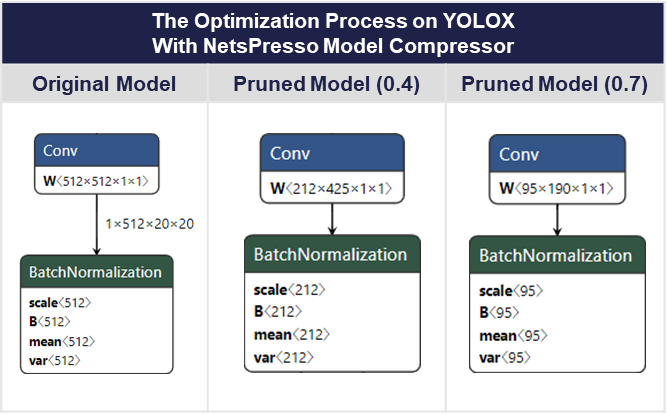
</div>
<div align='center'>Fig. 3 The optimization process for a single convolutional neural network in YOLOX with NetsPresso Model Compressor</div>


<a name="Accuracy-comparision"></a>
### Accuracy comparision

Evaluation code for the original model

In [ ]:
! python -m yolox.tools.eval -n yolox-l -c ../yolox_l.pth -b 1 -d 1 --conf 0.001

Evaluation code for the compressed model

Here, we load the model weights in `best_ckpt.pth` which is the result of fine-tuning process ([link](2.-Fine-tuning-the-Compressed-Model)).

In [ ]:
! python -m yolox.tools.eval -f ./exps/example/custom/yolox_l_compressed_model_L2Norm_04.py -b 1 -d 1 --conf 0.001 \
-c ./YOLOX_outputs/YOLOX_compressed_model_L2Norm_04/best_ckpt.pth

<a name="FLOPs-&-Parameters-comparision"></a>
### FLOPs & Parameters comparision

In [ ]:
import torch
from thop import profile
from exps.default.yolox_l import Exp as large_exp

device = 'cuda' if torch.cuda.is_available() else 'cpu'

yolox_l_original_model = large_exp().get_model().to(device)
yolox_l_compressed_model_l2norm_04 = torch.load('../YOLOX_l_compressed_model_L2Norm_04.pt', map_location='cpu').to(device)

dummy_input = torch.ones((1,3,640,640)).to(device)

original_macs, original_params = profile(yolox_l_original_model, inputs=(dummy_input, ))
compressed_macs, compressed_params = profile(yolox_l_compressed_model_l2norm_04, inputs=(dummy_input, ))

print("\n--- Original model ==> Compressed model ---")
print(f"FLOPs: {original_macs*2} ==> {compressed_macs*2} (x{round(original_macs/compressed_macs,3)})")
print(f"Params: {original_params} ==> {compressed_params} (x{round(original_params/compressed_params,3)})")

<a name="Latency-comparision"></a>
### Latency comparision

In [ ]:
import onnx
def onnxExport(model, model_name, device = torch.device('cpu')):
    model = model.to(device.type)
    dummy_input = torch.ones((1,3,640,640)).to(device.type)
    torch.onnx.export(model,dummy_input,model_name,verbose=False)

compressed_model = torch.load('../yolox_l_compressed_model_L2Norm_04.onnx',map_location='cpu')
onnxExport(compressed_model, 'YOLOX_l_compressed_model_L2Norm_04.onnx')

In [ ]:
import onnxruntime
import numpy as np

def inference_time(model_path,run_times):
    device = torch.device('cpu')
    img_size = 640
    so = onnxruntime.SessionOptions()
    so.execution_mode = onnxruntime.ExecutionMode.ORT_SEQUENTIAL
    so.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_EXTENDED
    exproviders = [ 'CPUExecutionProvider']
    ort_session = onnxruntime.InferenceSession(model_path, so, providers=exproviders)

    input_names = ort_session.get_inputs()[0].name
    output_names = ort_session.get_outputs()[0].name
    # warm up
    dummy_input = np.random.rand(1,3,640,640).astype(np.float32)
    for _ in range(10):
        #IOBinding
        data = onnxruntime.OrtValue.ortvalue_from_numpy(dummy_input, device.type, 0)
        io_binding = ort_session.io_binding()
        io_binding.bind_input(input_names, device.type, 0, np.float32, [1, 3, img_size, img_size], data.data_ptr())
        io_binding.bind_output(output_names, device.type)

        torch.cuda.synchronize()
        with torch.no_grad():
            ort_session.run_with_iobinding(io_binding)
        torch.cuda.synchronize()

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    latency = []
    for _ in range(run_times):
        dummy_input = np.random.rand(1,3,640,640).astype(np.float32)
        #IOBinding
        data = onnxruntime.OrtValue.ortvalue_from_numpy(dummy_input, device.type, 0)
        io_binding.bind_input(input_names, device.type, 0, np.float32, [1, 3, img_size, img_size], data.data_ptr())
        io_binding.bind_output(output_names, device.type)

        torch.cuda.synchronize()
        start.record() 
        with torch.no_grad():
            ort_session.run_with_iobinding(io_binding)
        end.record()
        torch.cuda.synchronize()
        time_elapsed = start.elapsed_time(end)
        latency.append(time_elapsed)
    return sum(latency)/len(latency)


original_latency = inference_time('../yolox_l.onnx',run_times=100)
compressed_latency = inference_time('../yolox_l_compressed_model_L2Norm_04.onnx',run_times=100)

print("Original Model ==> Compressed Model")
print(f"Latency: {round(original_latency,3)}ms ==> {round(compressed_latency,3)}ms (x{round(original_latency/compressed_latency,3)})")

<a name="Architecture-of-the-compressed-model"></a>

### Architecture of the compressed model

In [ ]:
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

compressed_model = torch.load('../yolox_l_compressed_model_L2Norm_04.onnx',map_location='cpu')
summary(compressed_model.to(device),(3,640,640),device=device)

# Appendix
In this section, we go into details about the code we've changed for model compression and fine-tuning.

### For exporting & compressing
*  `yolox_head_woLoss.py` & `yolox_woLoss.py` 
    * As mentioned [before](#Conversion-into-ONNX-Format), to compress YOLOX, we need to detach the loss calculating process in  `yolo_head`.
    * In `yolox_head_woLoss.py`, we detach the codes associated with the loss function [(link)](https://github.com/Megvii-BaseDetection/YOLOX/commit/08ea346147127525362a060ae0575689e816e2d3). The detached functions were added at the fine-tuning process (at `/yolox_l_compressed_model_L2Norm_04.py`).
    * In `yolox_woLoss.py`, as the output of the `yolo_head` changes, the yolox must be changed accordingly. [(link)](https://github.com/Megvii-BaseDetection/YOLOX/commit/5f716e01db6c0f3fec788149d8ecddb12ba3f800).
* `yolox_l_woLoss.py`
    * To use the detached model, a new experiment description file for it is must be defined. Here, we import `yolo_head_woLoss` and `yolox_woLoss` in the `get_model` function.  [(link)](https://github.com/Megvii-BaseDetection/YOLOX/commit/e4606c511639b92caa9eb7288ba4e6bbf7db13bf)
* `export_onnx_train.py` 
    * `export_onnx.py` provided from original YOLOX exports the model as evaluation mode. To export the model as training mode, we just add a training argument on the `torch.onnx.export` function [(link)](https://github.com/Megvii-BaseDetection/YOLOX/commit/bc7c51efa6c3068b0c76c7b0be293b102e8d0e49).

    
### For fine-tuning
* `yolox_l_compressed_model_L2Norm_04.py`
    * The compressed model's format is graphmodule and the model needs a calculating loss process. 
    * We define a new class `RetrainUtils` to use the loss function. The functions in the `RetrainUtils` are from [`yolo_head.py`](https://github.com/Megvii-BaseDetection/YOLOX/blob/main/yolox/models/yolo_head.py#L18). To attach the loss function from the compressed model, we also defined `compressed_YOLOX`. [(link)](https://github.com/dbwp031/YOLOX/commit/41dc682f8c5c1ee201543c297ebed8e08b9a6136#diff-30121b21f9d634fda0e20831d84e4c79f309d182f1360600b071bff65acd0b0dR19).
    * To load the graphmodule model, a newly defined `get_model` function is needed. [(link)](https://github.com/dbwp031/YOLOX/commit/41dc682f8c5c1ee201543c297ebed8e08b9a6136#diff-30121b21f9d634fda0e20831d84e4c79f309d182f1360600b071bff65acd0b0dR532).